# YouTube Analysis and Recommender System

In this notebook, we perform a detailed analysis of YouTube data to build a recommender system. YouTube, being one of the largest video-sharing platforms, holds a wealth of information that can be leveraged to understand user preferences, predict trends, and suggest relevant content.

## Overview

This project focuses on analyzing YouTube videos, their metadata, user interactions, and building a system that can recommend videos based on different factors such as view history, user preferences, and similar content.

## Objectives

- **Data Collection**: Retrieve YouTube video data, including video titles, descriptions, view counts, likes, and comments.
- **Data Preprocessing**: Clean and prepare the dataset for analysis.
- **Exploratory Data Analysis (EDA)**: Investigate patterns, trends, and insights from the dataset.
- **Recommender System**: Build a content-based or collaborative filtering recommender system to suggest videos to users.
- **Evaluation**: Evaluate the recommender system using appropriate metrics like accuracy, precision, and recall.

## Dataset

The dataset used in this analysis is collected from publicly available YouTube video statistics. It includes various features such as:

- Video Title
- Channel Name
- View Count
- Like Count
- Comment Count
- Video Description
- Tags
- Published Date

## Methodology

We will employ machine learning algorithms to build our recommender system. Depending on the approach, we might use:
- **Content-Based Filtering**: Recommending videos based on similarities between the content of videos.
- **Collaborative Filtering**: Recommending videos based on user interaction history and preferences.

The model will be evaluated based on the ability to suggest relevant and engaging videos to users.

## Conclusion

By the end of this notebook, we aim to have a fully functional recommender system capable of providing personalized video recommendations, enhancing user engagement, and improving their overall experience on YouTube.



## Initializing PySpark

Before using PySpark, we need to initialize the Spark session.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys

## Load the Data from a CSV file

In [3]:
filePath = os.path.join(os.getcwd(), "dataset", "trending_yt_videos_113_countries.csv")
data = pd.read_csv(filePath, sep=',')
data.head(5)

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,langauge
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,1,0,49,2025-02-20,ZW,640294,33578,6942,Our first single for 2025\nNot a part of the N...,https://i.ytimg.com/vi/hQGU7Hjr6KA/mqdefault.jpg,hQGU7Hjr6KA,UCPpVYvHuQSIkQwW1pJhfPrA,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN
1,Winky D - Siya,winkyonline,2,0,-1,2025-02-20,ZW,1483949,59662,10408,You can purchase the EP from stores below:\nSP...,https://i.ytimg.com/vi/Mq0J2Q4I71U/mqdefault.jpg,Mq0J2Q4I71U,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
2,Winky D Fake Love (Official Ai Video),winkyonline,3,0,-1,2025-02-20,ZW,1031541,48158,6185,You can purchase the EP from stores below:\nSP...,https://i.ytimg.com/vi/6YvoX8x6aCw/mqdefault.jpg,6YvoX8x6aCw,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,4,0,-1,2025-02-20,ZW,75930862,2735285,161203,Watch hip-hop’s MVP put on an epic performance...,https://i.ytimg.com/vi/KDorKy-13ak/mqdefault.jpg,KDorKy-13ak,UCDVYQ4Zhbm3S2dlz7P1GBDg,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,5,45,45,2025-02-20,ZW,4166631,64473,3630,Manchester City were knocked out this season’s...,https://i.ytimg.com/vi/zpieZkvFnlE/mqdefault.jpg,zpieZkvFnlE,UCkzCjdRMrW2vXLx8mvPVLdQ,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB


# YouTube Dataset: Explicit vs. Implicit Data

Explicit data refers to information that is directly provided by the user, platform, or content creators,
whereas implicit data refers to information that is generated based on user interaction, platform algorithms, or system tracking.
In our dataset, we have a combination of both types of data, separated as follows:

## Explicit Data

- **title**: The title of the video, explicitly set by the uploader.
- **channel_name**: The name of the YouTube channel that uploaded the video.
- **description**: The text description provided by the video uploader.
- **thumbnail_url**: The URL of the thumbnail, explicitly assigned or auto-generated by YouTube.
- **video_id**: A unique identifier for the video, assigned by YouTube.
- **channel_id**: A unique identifier for the channel, assigned by YouTube.
- **video_tags**: Tags provided by the content creator for categorization and search optimization.
- **kind**: Indicates the type of content (e.g., YouTube video).
- **publish_date**: The date when the video was published, explicitly recorded by YouTube.
- **language** (or "langauge" as it appears in your dataset): The language setting for the video, either set by the uploader or inferred by YouTube.

## Implicit Data

- **daily_rank**: The ranking of the video for a given day, derived from engagement metrics.
- **daily_movement**: The change in ranking from the previous day, inferred from user engagement trends.
- **weekly_movement**: The ranking shift over a week, based on aggregated engagement data.
- **snapshot_date**: The date when the data was collected, recorded by the system.
- **country**: The country where the video is trending or where the snapshot was taken, inferred from viewer location data.
- **view_count**: The number of views the video has received, recorded and updated by YouTube.
- **like_count**: The number of likes, tracked as users interact with the content.
- **comment_count**: The number of comments, generated from user interactions.


## Filtering columns

As a starter to our project, we decided to cut some of the variables that are less likely to be userful in user recommendation. If needed, we will reload some of the columns needed.

In [4]:
columns_useful = ['title', 'channel_name', 'view_count', 'like_count', 'comment_count', 
                  'video_tags', 'kind', 'publish_date', 'langauge']

# Filter the columns that exist in the dataframe
columns_validas = [c for c in columns_useful if c in data.columns]

# Select only the valid columns
data = data[columns_validas]

# Display the first 5 rows
data.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,640294,33578,6942,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN
1,Winky D - Siya,winkyonline,1483949,59662,10408,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
2,Winky D Fake Love (Official Ai Video),winkyonline,1031541,48158,6185,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,75930862,2735285,161203,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,4166631,64473,3630,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB


## Generating new dimensions

We decided to create a new column called "Engagement Score" that uses a function of weights to generate a number that explains user interaction with the video.

We used a simple formula as shown below: 

$$
\text{Engagement Score} = \frac{\text{like\_count} \times 2 + \text{comment\_count} \times 3}{\text{view\_count} + 1}
$$


We decided to use these weights taking account the level of effort the user needs to put in order to perform these actions, meaning that they are more important the harder it is to do. The +1 on the view count is in order to avoid divisions by zero.

In [5]:
# Creating the engagement score column
data['engagement_score'] = (data['like_count'] * 2 + data['comment_count'] * 3) / (data['view_count'] + 1)

# Sorting by engagement score in descending order
data_sorted = data.sort_values(by='engagement_score', ascending=False)

# Display the first 5 rows
data_sorted.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge,engagement_score
876704,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,456719,11537,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,948049.0
882352,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,455188,11468,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,944780.0
887999,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,453200,11386,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,940558.0
893641,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,450683,11282,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,935212.0
899284,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,0,447515,11143,NaN,youtube#video,2024-09-08 00:00:00+00:00,NaN,928459.0


## Normalising the Score

In [6]:
# Calculate min and max values of the engagement_score
min_score = data['engagement_score'].min()
max_score = data['engagement_score'].max()

# Create the scaled engagement score column
data['scaled_engagement_score'] = 1 + 9 * ((data['engagement_score'] - min_score) / (max_score - min_score))

# Select the relevant columns and sort by scaled_engagement_score in descending order
data_sorted = data[['title', 'engagement_score', 'scaled_engagement_score']].sort_values(by='scaled_engagement_score', ascending=False)

# Display the first 5 rows
data_sorted.head(5)



,title,engagement_score,scaled_engagement_score
876704,THE WEEKND - SÃO PAULO LIVESTREAM,948049.0,10.000000
882352,THE WEEKND - SÃO PAULO LIVESTREAM,944780.0,9.968967
887999,THE WEEKND - SÃO PAULO LIVESTREAM,940558.0,9.928887
893641,THE WEEKND - SÃO PAULO LIVESTREAM,935212.0,9.878136
899284,THE WEEKND - SÃO PAULO LIVESTREAM,928459.0,9.814029


## Data Association

We will now dive deeper in our dataset, generating different datasets that provide different information on our data

In [7]:
# Group by 'channel_name' and calculate the average engagement score
channel_engagement = data.groupby('channel_name')['engagement_score'].mean().reset_index()
channel_engagement = channel_engagement.rename(columns={'engagement_score': 'avg_engagement_score'})

# Calculate min and max of avg_engagement_score
min_score_channel = channel_engagement['avg_engagement_score'].min()
max_score_channel = channel_engagement['avg_engagement_score'].max()

# Create the scaled average engagement score column
channel_engagement['scaled_avg_engagement_score'] = 1 + 9 * ((channel_engagement['avg_engagement_score'] - min_score_channel) / (max_score_channel - min_score_channel))

# Sort by avg_engagement_score in descending order
channel_analysis = channel_engagement.sort_values(by='avg_engagement_score', ascending=False)

# Display the top 10 rows
channel_analysis.head(10)


,channel_name,avg_engagement_score,scaled_avg_engagement_score
26687,The Weeknd,267825.547331,10.000000
5557,Coachella,226829.630104,8.622375
10524,GoogleDoodles,165461.954545,6.560178
1674,Alok,23462.932742,1.788448
13857,Kenia Os,18924.956264,1.635954
8695,FORMULA 1,6430.476832,1.216090
9282,Flow Podcast,3586.588321,1.120524
13273,KAROL G,363.453403,1.012213
255,2SekundovyMato,90.802832,1.003051
19466,Nour Chiba نور شيبة,1.296628,1.000044


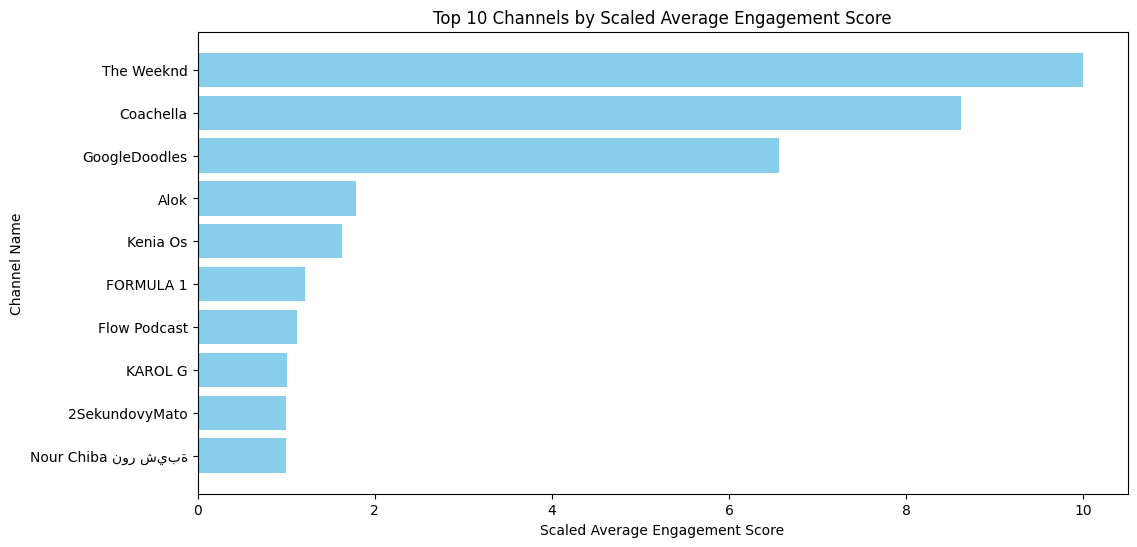

In [8]:
channel_analysis = channel_analysis.sort_values(by="scaled_avg_engagement_score", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(channel_analysis["channel_name"][:10], channel_analysis["scaled_avg_engagement_score"][:10], color='skyblue')
plt.xlabel("Scaled Average Engagement Score")
plt.ylabel("Channel Name")
plt.title("Top 10 Channels by Scaled Average Engagement Score")
plt.gca().invert_yaxis() 
plt.show()

## Lets try to find similarities between videos

In [9]:
data.head(5)

,title,channel_name,view_count,like_count,comment_count,video_tags,kind,publish_date,langauge,engagement_score,scaled_engagement_score
0,Jah Prayzah - Mandionei (Official Performance ...,Jah Prayzah,640294,33578,6942,NaN,youtube#video,2025-02-17 00:00:00+00:00,NaN,0.137409,1.000001
1,Winky D - Siya,winkyonline,1483949,59662,10408,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN,0.101451,1.000001
2,Winky D Fake Love (Official Ai Video),winkyonline,1031541,48158,6185,NaN,youtube#video,2025-02-01 00:00:00+00:00,NaN,0.111359,1.000001
3,Kendrick Lamar's Apple Music Super Bowl Halfti...,NFL,75930862,2735285,161203,"NFL, Football, American Football, sport, sports",youtube#video,2025-02-10 00:00:00+00:00,en,0.078416,1.000001
4,HIGHLIGHTS Real Madrid 3-1 Man City | Mbappe (...,Man City,4166631,64473,3630,"man city, manchester city, mcfc, man city high...",youtube#video,2025-02-20 00:00:00+00:00,en-GB,0.033561,1.000000


In [10]:
from scipy.spatial.distance import pdist, squareform

# Select only the numeric columns
numeric_data = data.select_dtypes(include=['number'])

chunk_size = 500  # Adjust chunk size based on available memory
chunks = [numeric_data.iloc[i:i+chunk_size] for i in range(0, numeric_data.shape[0], chunk_size)]

distance_matrices = []

for chunk in chunks:
    distance_matrix = pdist(chunk, metric='euclidean')
    distance_matrix_square = squareform(distance_matrix)
    distance_matrices.append(distance_matrix_square)

# Now, pad the last chunk if necessary
# Determine the largest matrix size (assumed to be the first chunk size)
max_rows = distance_matrices[0].shape[0]

# Pad all the distance matrices to the same size
padded_distance_matrices = [
    np.pad(matrix, ((0, max_rows - matrix.shape[0]), (0, max_rows - matrix.shape[1])), mode='constant', constant_values=0)
    for matrix in distance_matrices
]

# Concatenate the matrices
full_distance_matrix = np.concatenate(padded_distance_matrices, axis=0)

# Convert to DataFrame for easier manipulation
distance_matrix_df = pd.DataFrame(full_distance_matrix)

distance_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000e+00,8.440653e+05,3.915193e+05,7.533918e+07,3.526474e+06,9.919704e+06,5.188247e+05,8.803859e+07,4.210287e+05,1.054559e+05,...,4.664970e+07,5.188764e+05,1.226625e+05,5.857612e+05,5.558486e+05,3.682876e+06,5.690272e+05,5.256785e+05,2.038111e+05,5.142578e+05
1,8.440653e+05,0.000000e+00,4.525739e+05,7.449513e+07,2.682695e+06,9.075733e+06,1.362832e+06,8.719457e+07,1.264744e+06,9.494227e+05,...,4.580591e+07,1.362825e+06,7.217371e+05,1.429700e+06,1.399762e+06,2.839067e+06,1.412951e+06,1.369624e+06,1.047866e+06,1.358135e+06
2,3.915193e+05,4.525739e+05,0.000000e+00,7.494767e+07,3.135133e+06,9.528268e+06,9.103082e+05,8.764708e+07,8.123386e+05,4.968952e+05,...,4.625825e+07,9.103313e+05,2.692563e+05,9.772140e+05,9.472855e+05,3.291519e+06,9.604712e+05,9.171313e+05,5.953168e+05,9.056721e+05
3,7.533918e+07,7.449513e+07,7.494767e+07,0.000000e+00,7.181409e+07,6.542149e+07,7.585794e+07,1.270396e+07,7.575978e+07,7.544454e+07,...,2.871442e+07,7.585792e+07,7.521682e+07,7.592479e+07,7.589484e+07,7.165763e+07,7.590804e+07,7.586472e+07,7.554298e+07,7.585321e+07
4,3.526474e+06,2.682695e+06,3.135133e+06,7.181409e+07,0.000000e+00,6.393427e+06,4.044912e+06,8.451386e+07,3.946511e+06,3.631693e+06,...,4.312748e+07,4.044792e+06,3.404004e+06,4.111615e+06,4.081652e+06,1.564806e+05,4.094851e+06,4.051585e+06,3.730184e+06,4.040002e+06


# Clustering


In [18]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Define features
feature_cols = ["view_count", "like_count", "comment_count", "scaled_engagement_score"]

# Assemble features
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_vector = vector_assembler.transform(data)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data_vector)
data_scaled = scaler_model.transform(data_vector)


In [19]:
# Apply KMeans clustering
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=4, seed=42)
kmeans_model = kmeans.fit(data_scaled)

# Generate predictions
data_clustered = kmeans_model.transform(data_scaled)

# Verify if prediction column exists
data_clustered.select("title", "channel_name", "view_count", "like_count", "comment_count", "cluster").show(10)


25/03/11 17:08:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+--------------------+------------+-----------+----------+-------------+-------+
|               title|channel_name| view_count|like_count|comment_count|cluster|
+--------------------+------------+-----------+----------+-------------+-------+
|Jah Prayzah - Man...| Jah Prayzah|   640294.0|   33578.0|       6942.0|      0|
|      Winky D - Siya| winkyonline|  1483949.0|   59662.0|      10408.0|      0|
|Winky D Fake Love...| winkyonline|  1031541.0|   48158.0|       6185.0|      0|
|Kendrick Lamar's ...|         NFL|7.5930862E7| 2735285.0|     161203.0|      3|
|HIGHLIGHTS Real M...|    Man City|  4166631.0|   64473.0|       3630.0|      0|
|HIGHLIGHTS Man Ci...|    Man City|1.0558534E7|  203986.0|       8784.0|      0|
|            PA TONAZ| Comic Elder|   122104.0|    8758.0|        446.0|      0|
|Reach the Money, ...|     MrBeast|8.8610239E7| 3509581.0|       4820.0|      3|
|Bagga - Pengeleng...|  Baggamusic|   220647.0|       0.0|       1107.0|      0|
|Winky D ft Bling ...| winky

In [20]:
# Evaluate clustering performance
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_score = evaluator.evaluate(data_clustered)
print(f"Silhouette Score: {silhouette_score:.4f}")


Silhouette Score: 0.8712


In [21]:
data_clustered.select("title", "channel_name", "view_count", "like_count", "comment_count", "cluster").show(10)

+--------------------+------------+-----------+----------+-------------+-------+
|               title|channel_name| view_count|like_count|comment_count|cluster|
+--------------------+------------+-----------+----------+-------------+-------+
|Jah Prayzah - Man...| Jah Prayzah|   640294.0|   33578.0|       6942.0|      0|
|      Winky D - Siya| winkyonline|  1483949.0|   59662.0|      10408.0|      0|
|Winky D Fake Love...| winkyonline|  1031541.0|   48158.0|       6185.0|      0|
|Kendrick Lamar's ...|         NFL|7.5930862E7| 2735285.0|     161203.0|      3|
|HIGHLIGHTS Real M...|    Man City|  4166631.0|   64473.0|       3630.0|      0|
|HIGHLIGHTS Man Ci...|    Man City|1.0558534E7|  203986.0|       8784.0|      0|
|            PA TONAZ| Comic Elder|   122104.0|    8758.0|        446.0|      0|
|Reach the Money, ...|     MrBeast|8.8610239E7| 3509581.0|       4820.0|      3|
|Bagga - Pengeleng...|  Baggamusic|   220647.0|       0.0|       1107.0|      0|
|Winky D ft Bling ...| winky

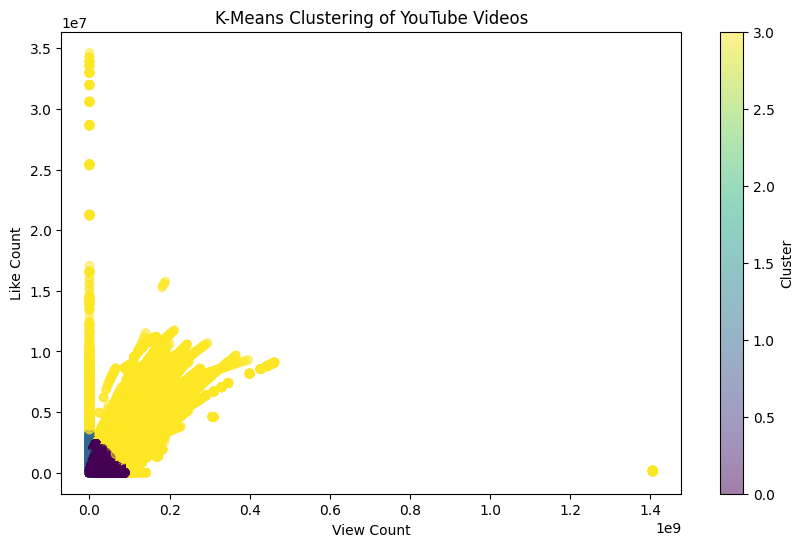

In [22]:
df_plot = data_clustered.select("view_count", "like_count", "comment_count", "cluster").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(df_plot["view_count"], df_plot["like_count"], c=df_plot["cluster"], cmap="viridis", alpha=0.5)
plt.xlabel("View Count")
plt.ylabel("Like Count")
plt.title("K-Means Clustering of YouTube Videos")
plt.colorbar(label="Cluster")
plt.show()


# Sentiment Analysis

Now we will focus on analysing and filtering important data on the tags and title columns. With this method, we will be able to identify key words to generate relationships

In [59]:
import nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StopWordsRemover
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/adriana/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/adriana/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nlt

True

In [69]:
data_scaled.show()

+--------------------+--------------------+-----------+----------+-------------+--------------------+-------------+--------------------+--------+--------------------+-----------------------+--------------------+--------------------+
|               title|        channel_name| view_count|like_count|comment_count|          video_tags|         kind|        publish_date|langauge|    engagement_score|scaled_engagement_score|            features|     scaled_features|
+--------------------+--------------------+-----------+----------+-------------+--------------------+-------------+--------------------+--------+--------------------+-----------------------+--------------------+--------------------+
|Jah Prayzah - Man...|         Jah Prayzah|   640294.0|   33578.0|       6942.0|                NULL|youtube#video|2025-02-17 00:00:...|    NULL| 0.13740853825189953|     1.0000327373041344|[640294.0,33578.0...|[-0.2365294517775...|
|      Winky D - Siya|         winkyonline|  1483949.0|   59662.0|  

In [70]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

In [73]:
def process_tags(tags):
    if tags is None:
        return "Neutral"

    # Tokenización
    tokens = word_tokenize(tags.lower())  # Convertir a minúsculas y tokenizar
    
    # Remover stopwords y lematizar
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    # Unir los tokens procesados
    processed_text = " ".join(filtered_tokens)

    # Análisis de sentimiento
    sentiment_score = sia.polarity_scores(processed_text)['compound']
    
    # Asignar una categoría según el puntaje
    if sentiment_score >= 0.05:
        return "Positive"
    elif sentiment_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [74]:
process_tags_udf = udf(process_tags, StringType())

# Aplicar la función a la columna de tags
data_sentiment = data_scaled.withColumn("sentiment", process_tags_udf(data_scaled["video_tags"]))

# Mostrar los resultados
data_sentiment.select("video_tags", "sentiment").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|video_tags                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |sentiment|
+-------------------------

In [75]:
data_sentiment.select("video_tags").show(10, truncate=False)  # Verifica el contenido real
data_sentiment.filter(data_sentiment.video_tags.isNull()).show()  # Busca valores NULL

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|video_tags                                                                                                                                                                                                                                                                              |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|NULL                                                                                                                                                  

In [76]:
data_sentiment = data_sentiment.fillna({"video_tags": ""})

In [77]:
tokenizer = Tokenizer(inputCol="video_tags", outputCol="words")
data_tokens = tokenizer.transform(data_sentiment)

In [78]:
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
data_filtered = stopwords_remover.transform(data_tokens)

In [79]:
data_filtered.show()

+--------------------+--------------------+-----------+----------+-------------+--------------------+-------------+--------------------+--------+--------------------+-----------------------+--------------------+--------------------+---------+--------------------+--------------------+
|               title|        channel_name| view_count|like_count|comment_count|          video_tags|         kind|        publish_date|langauge|    engagement_score|scaled_engagement_score|            features|     scaled_features|sentiment|               words|      filtered_words|
+--------------------+--------------------+-----------+----------+-------------+--------------------+-------------+--------------------+--------+--------------------+-----------------------+--------------------+--------------------+---------+--------------------+--------------------+
|Jah Prayzah - Man...|         Jah Prayzah|   640294.0|   33578.0|       6942.0|                    |youtube#video|2025-02-17 00:00:...|    NULL|

In [87]:
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)
data_tf = hashing_tf.transform(data_filtered)

In [88]:
if data_tf.count() > 0:
    idf = IDF(inputCol="raw_features", outputCol="sentiment_features")
    idf_model = idf.fit(data_tf)
    data_tfidf = idf_model.transform(data_tf)
else:
    print("Error: No hay datos válidos en raw_features para aplicar IDF.")

In [89]:
def recommend_videos(user_sentiment, num_recommendations=5):
    # Filtrar videos con el mismo sentimiento
    filtered_videos = data_tfidf.filter(col("sentiment") == user_sentiment)

    # Convertir a numpy array para similitud de coseno
    features_matrix = np.array(filtered_videos.select("sentiment_features").rdd.map(lambda x: x[0].toArray()).collect())

    # Calcular similitud de coseno
    similarity_matrix = cosine_similarity(features_matrix)

    # Obtener los índices de los videos más similares
    recommended_indices = np.argsort(-similarity_matrix.sum(axis=0))[:num_recommendations]

    # Obtener los títulos recomendados
    recommended_titles = filtered_videos.select("title").rdd.zipWithIndex().filter(lambda x: x[1] in recommended_indices).map(lambda x: x[0]).collect()

    return recommended_titles

In [91]:
spark.catalog.clearCache()

ConnectionRefusedError: [Errno 111] Connection refused

In [90]:
recommended_videos = recommend_videos("Positive", num_recommendations=5)

# Mostrar recomendaciones
print("Videos recomendados:")
for video in recommended_videos:
    print(video)

25/03/11 17:43:50 ERROR Executor: Exception in task 0.0 in stage 120.0 (TID 112)
java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:776)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.Tr

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 57464)
Traceback (most recent call last):
  File "/usr/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/home/adriana/myproject/bigdataenv/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/adriana/myproject/bigdataenv/lib/python3.12/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/home/adriana/myproject/bigdataenv/lib

ConnectionRefusedError: [Errno 111] Connection refused

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/adriana/myproject/bigdataenv/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/adriana/myproject/bigdataenv/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adriana/myproject/bigdataenv/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


With the ability to find videos based on sentiment results, we can now expand to providing especific inputs, as a "new users", to obtain recommendations